In [1]:
from __future__ import division
from pyod.models.lunar import LUNAR
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
import matplotlib.font_manager
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
from numpy import percentile
import numpy as np
import warnings
from __future__ import print_function
from sklearn.datasets import make_blobs, make_moons
import os
import sys
import time
import seaborn as sns



import tensorflow as tf
import numpy as np

In [2]:
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

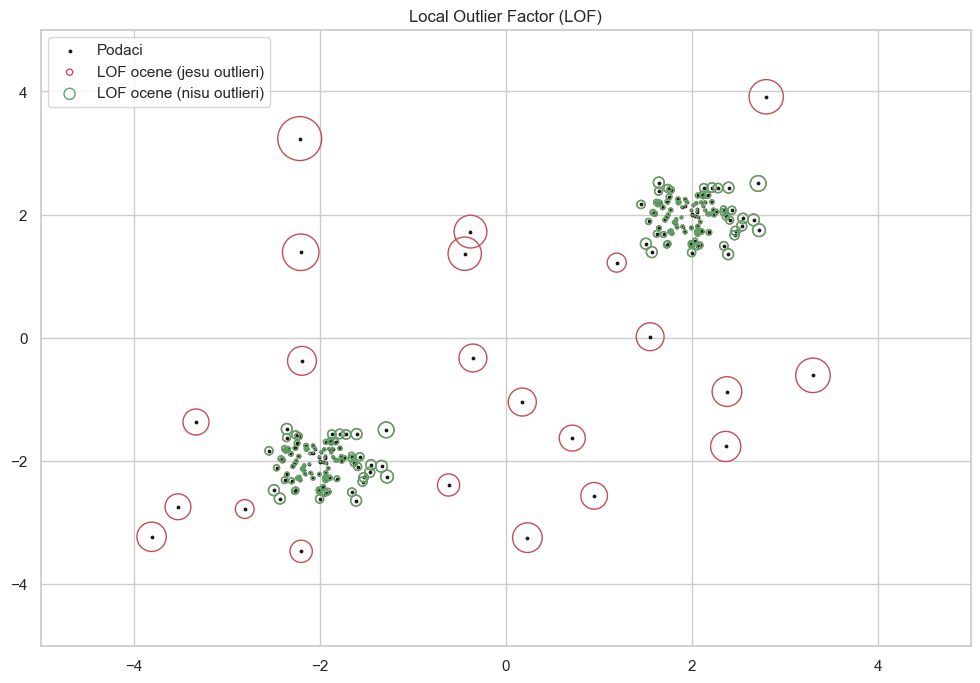

In [10]:
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers - 2, X_inliers + 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

clf = LOF(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = -clf.decision_scores_


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Podaci")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="LOF ocene (jesu outlieri)",
)

inlier_mask = y_pred == 0
plt.scatter(
    X[inlier_mask][:, 0],
    X[inlier_mask][:, 1],
    s=1000*radius[inlier_mask],
    facecolors="none",
    edgecolors="g",
    label="LOF ocene (nisu outlieri)",
)

plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    handler_map={scatter: HandlerPathCollection(
        update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

In [7]:
class MyAutoEncoder:
    def __init__(self, contamination=0.1):
        encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(1)  
        ])

        decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(2)  
        ])

        autoencoder = tf.keras.Sequential([
            encoder,
            decoder
        ])

        autoencoder.compile(loss="mse")
        self.autoencoder = autoencoder
        self.contamination = contamination

    def fit(self, X, epochs=100):
        shuffled_points = tf.random.shuffle(X)
        self.autoencoder.fit(
            x=shuffled_points, 
            y=shuffled_points,  
            validation_split=0.2,  
            epochs=epochs
        )

    def decision_function(self, X):
        reconstructed_X = self.autoencoder(X)
        result = tf.reduce_sum(
            (reconstructed_X - X)**2,
            axis=1
        )
        result_array = np.array(result)

        return result_array

    def predict(self, X):
        decision_values = self.decision_function(X)
        sorted_indices = np.argsort(decision_values)[::-1]
        top_index = int(len(X) * self.contamination)
        labels = np.zeros(len(X))
        labels[sorted_indices[:top_index]] = 1

        return labels.astype(bool)
    
    def reconstruct(self,X):
        return self.autoencoder(X)

In [4]:
tf.random.set_seed(1234)

t = tf.expand_dims(tf.linspace(0., 2*3.14, 1000), -1)
noise = tf.random.normal((1000, 2), stddev=0.05)
points = tf.concat([tf.cos(t), tf.sin(t)], axis=1) + noise
outliers = tf.random.uniform((50, 2), minval=-1.2, maxval=1.2)
points_with_outliers = tf.concat(
    [
        points,
        outliers  
    ],
    axis=0)


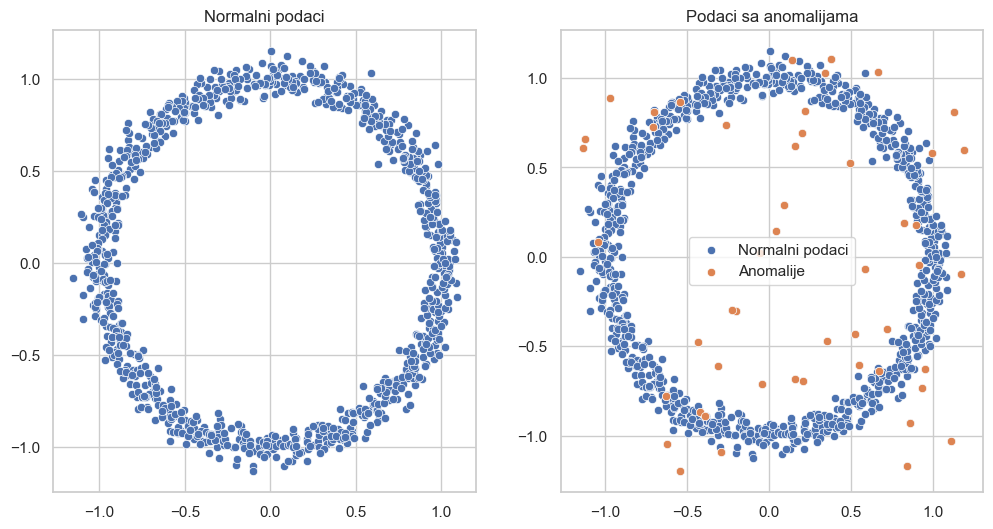

In [5]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=points[:, 0], y=points[:, 1])
plt.title("Normalni podaci")
plt.subplot(1, 2, 2)
sns.scatterplot(x=points_with_outliers[:, 0],
                y=points_with_outliers[:, 1], label='Normalni podaci')
sns.scatterplot(x=outliers[:, 0],
                y=outliers[:, 1], label='Anomalije')
plt.title("Podaci sa anomalijama")
plt.savefig('inliers_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
shuffled_points = tf.random.shuffle(points)
autoencoder=MyAutoEncoder()
autoencoder.fit(shuffled_points,epochs=500)
reconstructed_points = autoencoder.reconstruct(points_with_outliers)

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4863 - val_loss: 0.4155
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3845 - val_loss: 0.3104
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3013 - val_loss: 0.2422
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2600 - val_loss: 0.2175
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2447 - val_loss: 0.1988
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2284 - val_loss: 0.1790
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2112 - val_loss: 0.1626
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1954 - val_loss: 0.1473
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1812 - val_loss: 0.1326
Epoch 10/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1685 - val_loss: 0.1215
Epoch 11/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1576 - val_loss: 0.1124
Epoch 12/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1

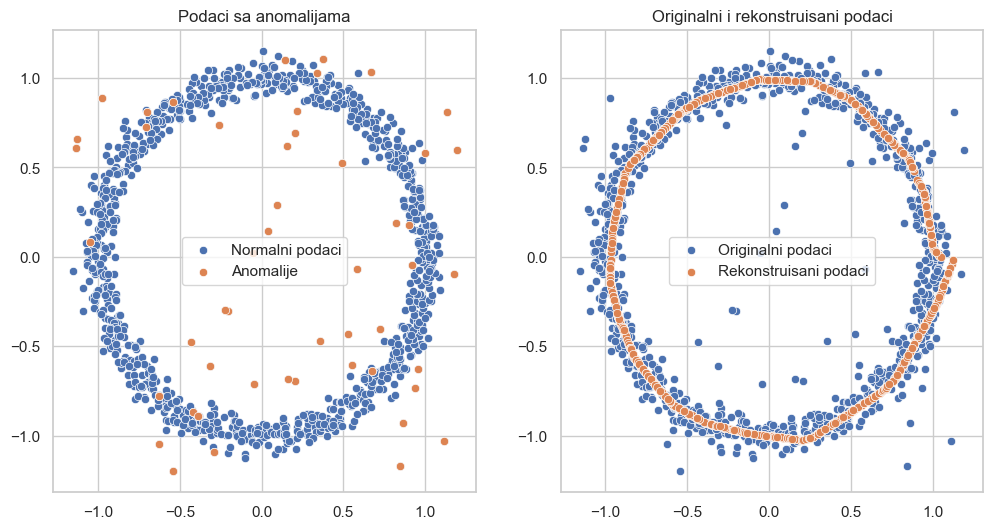

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=points_with_outliers[:, 0],
                y=points_with_outliers[:, 1], label='Normalni podaci')
sns.scatterplot(x=outliers[:, 0],
                y=outliers[:, 1], label='Anomalije')
plt.title("Podaci sa anomalijama")
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=points_with_outliers[:, 0], y=points_with_outliers[:, 1], label="Originalni podaci")
sns.scatterplot(
    x=reconstructed_points[:, 0], y=reconstructed_points[:, 1], label="Rekonstruisani podaci")
plt.title("Originalni i rekonstruisani podaci")
plt.savefig('reconstructed.png', dpi=300)
plt.show()

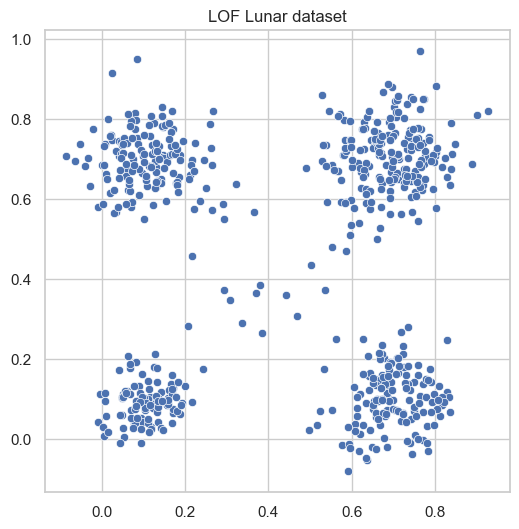

In [72]:
lof_lunar_dataset = np.concatenate([
    make_blobs(centers=[[0.1, 0.1], [0.1, 0.7], [0.7, 0.1], [0.7, 0.7]],
               cluster_std=[0.051, 0.07, 0.07, 0.08],
               n_samples=[100, 150, 150, 200],
               n_features=2,)[0],
    np.random.uniform(0.2, 0.6, (20, 2)),
])

plt.figure(figsize=(6, 6))
sns.scatterplot(x=lof_lunar_dataset[:, 0], y=lof_lunar_dataset[:, 1])
plt.title("LOF Lunar dataset")
plt.show()

In [73]:
lof = LOF(n_neighbors=20, contamination=0.05)
lof.fit(lof_lunar_dataset)
lunar = LUNAR()
lunar.fit(lof_lunar_dataset[:-30])

LUNAR(contamination=0.1, epsilon=0.1, lr=0.001, model_type='WEIGHT',
   n_epochs=200, n_neighbours=5, negative_sampling='MIXED', proportion=1.0,
   scaler=MinMaxScaler(), val_size=0.1, verbose=0, wd=0.1)

In [98]:
xx, yy = np.meshgrid(np.linspace(-0.15, 1, 100), np.linspace(-0.15, 1, 100))

X = lof_lunar_dataset
inliers = X[:-30]
outliers = X[-30:]
n_inliers = 600
n_outliers = 30
outliers_fraction = (n_outliers)/(n_outliers+n_inliers)
ground_truth = np.zeros(n_inliers + n_outliers, dtype=int)
ground_truth[-n_outliers:] = 1


def plot_method(clf, num, title=None, ylabel=None):
    clf.fit(X)
    scores_pred = clf.decision_function(X) * -1
    y_pred = clf.predict(X)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    print(ground_truth.shape, y_pred.shape)

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(2, 2, num)
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                     cmap=plt.cm.Blues_r)
    # a = subplot.contour(xx, yy, Z, levels=[threshold],
    #                     linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                     colors='orange')
    b = subplot.scatter(X[y_pred == False, 0], X[y_pred == False, 1], c='black', marker='x',
                        s=20, )
    c = subplot.scatter(X[y_pred == True, 0], X[y_pred == True, 1], c='red', marker='s',
                        s=20, )
    if title:
        subplot.set_title(title)
    if ylabel:
        subplot.set_ylabel(ylabel)

(630,) (620,)
(630,) (620,)
(630,) (620,)
(630,) (620,)


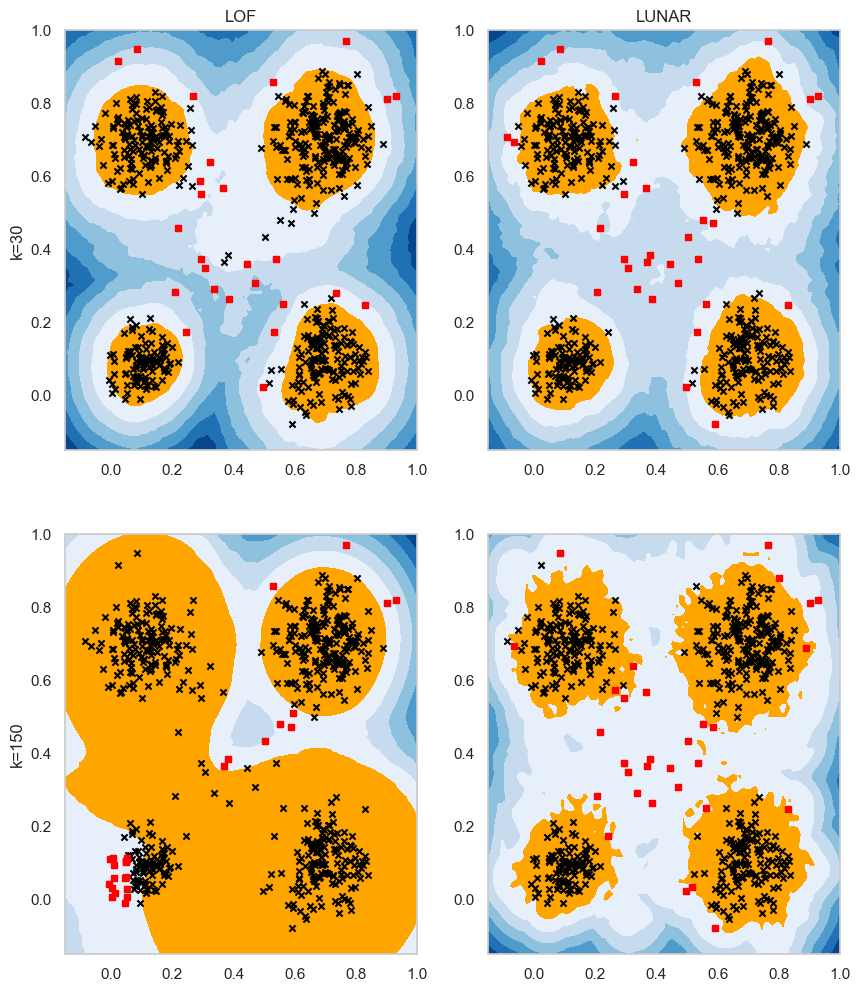

In [99]:

plt.figure(figsize=(10, 12))

plot_method(LOF(n_neighbors=30, contamination=0.05),
            1, title="LOF", ylabel="k=30")
plot_method(LUNAR(n_neighbours=30, contamination=0.05), 2, title="LUNAR")
plot_method(LOF(n_neighbors=150, contamination=0.05), 3, ylabel="k=150")
plot_method(LUNAR(n_neighbours=150, contamination=0.05), 4)

plt.savefig('lof_lunar.png', dpi=300, bbox_inches='tight')
plt.show()

Number of inliers: 900
Number of outliers: 100
Ground truth shape is (1000,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

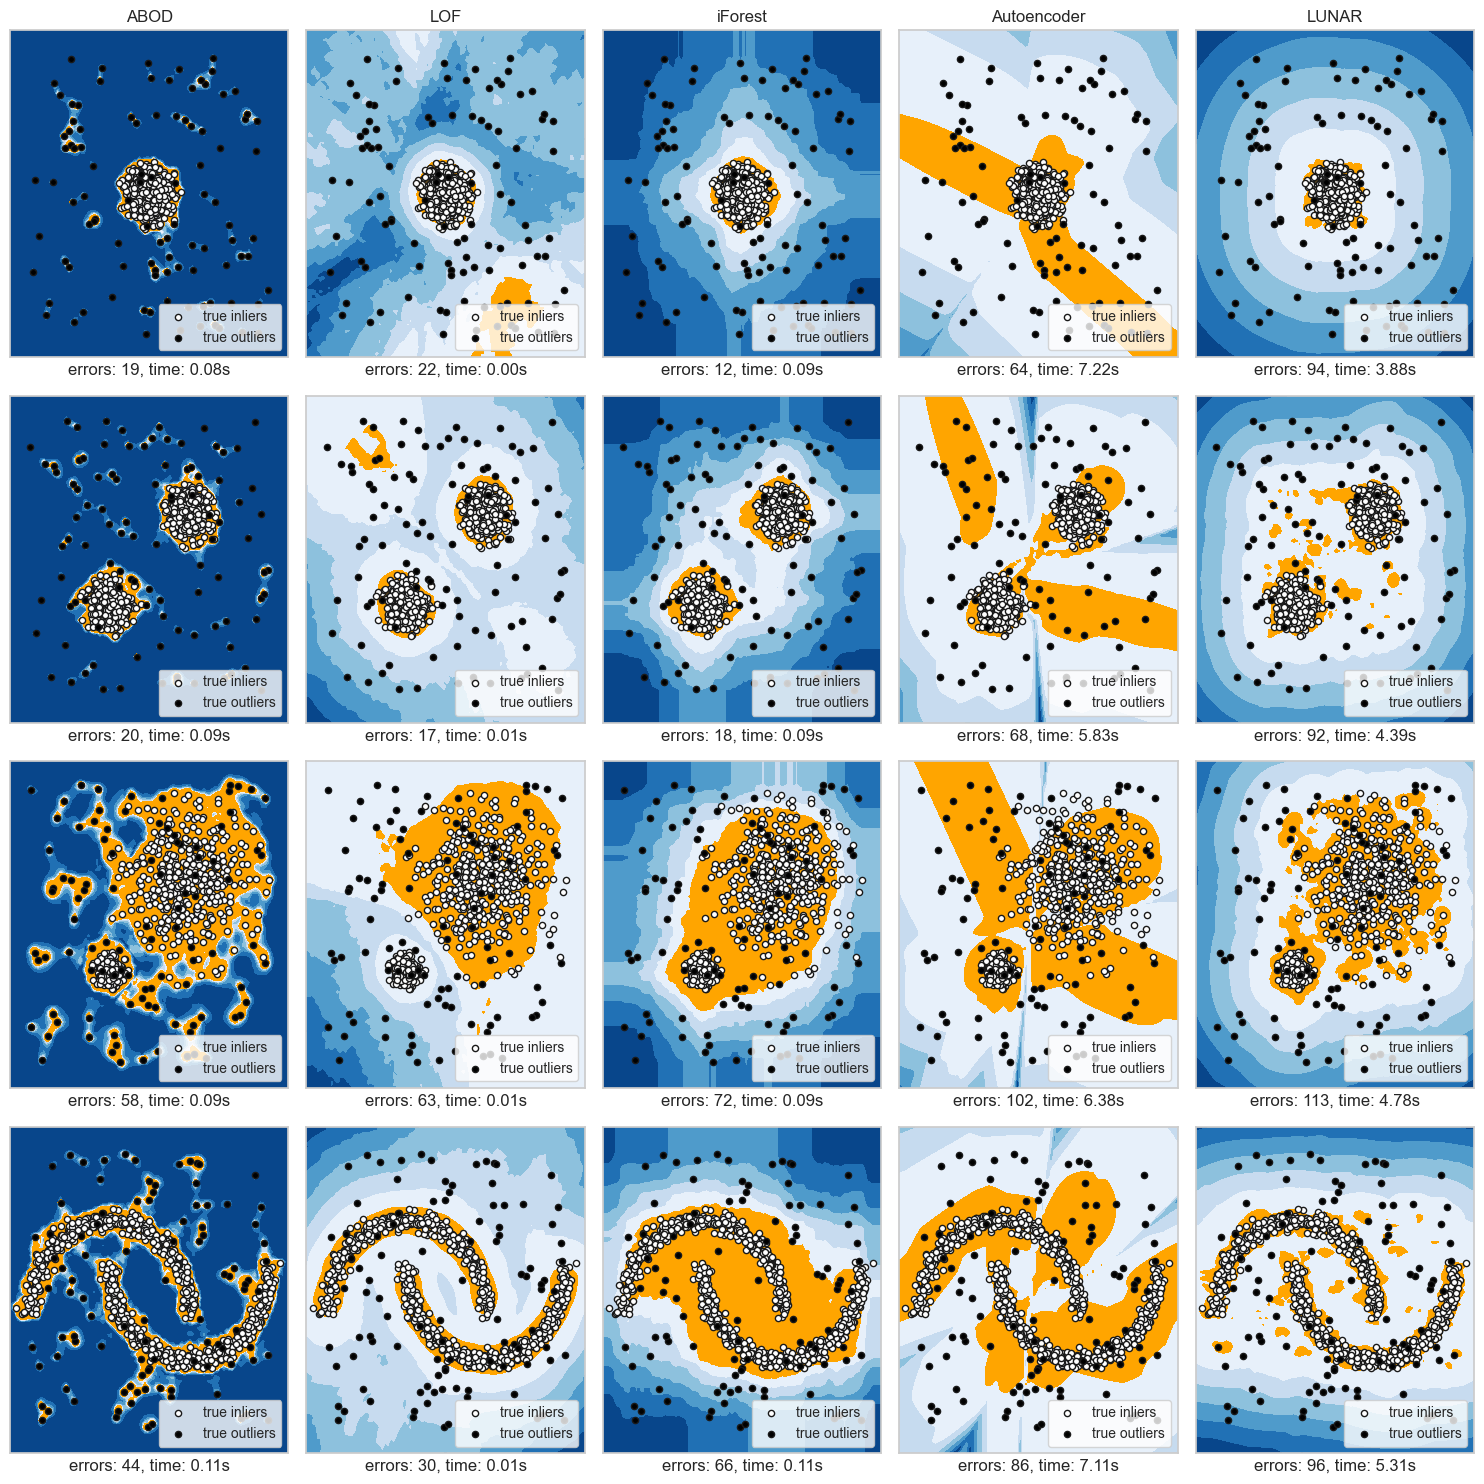

In [34]:

n_samples = 1000
outliers_fraction = 0.1
#clusters_separation = [0]


xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_inliers, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
]
for i in range(len(datasets)):
    datasets[i] = np.concatenate([datasets[i], np.random.uniform(
        low=-6, high=6, size=(n_outliers, 2))], axis=0)


print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print(
    'Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(
        shape=ground_truth.shape))
print(ground_truth, '\n')

random_state = 42
classifiers = {
    'ABOD':
        ABOD(contamination=outliers_fraction),
    'LOF':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'iForest': IForest(contamination=outliers_fraction,
                           random_state=random_state),
    'Autoencoder': MyAutoEncoder(),
    'LUNAR': LUNAR(),


}

for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

#for i, offset in enumerate(clusters_separation):
np.random.seed(42)

plt.figure(figsize=(15, 15))
num = 1
for dataset in datasets:
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        X = dataset
        inliers = X[:n_inliers]
        outliers = X[n_inliers:]
        print()
        print(X.shape)
        print(i + 1, 'fitting', clf_name)
        t1 = time.time()
        if clf_name in ['AutoEncoder', 'LUNAR']:
            clf.fit(inliers)
        else:
            clf.fit(X)
        t2 = time.time()
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        print(ground_truth.shape, y_pred.shape)
        n_errors = (y_pred.astype(np.int32) !=
                    ground_truth.astype(np.int32)).astype(np.int32).sum()

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(4, 5, num)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                            cmap=plt.cm.Blues_r)

        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                            colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [b, c],
            ['true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("errors: %d, time: %.2fs" %
                            (n_errors, t2-t1))
        plt.xticks(())
        plt.yticks(())
        if num < len(classifiers)+1:
            subplot.set_title(clf_name)
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
        num += 1
plt.tight_layout()

plt.savefig('ALL.png', dpi=300, bbox_inches='tight')
plt.show()